## Bayesian Optimization with Scikit-Optimize

In this notebook, we will perform **Bayesian Optimization** with Gaussian Processes in Parallel, utilizing various CPUs, to speed up the search.

This is useful to reduce search times.

https://scikit-optimize.readthedocs.io/en/latest/auto_examples/parallel-optimization.html#sphx-glr-auto-examples-parallel-optimization-py

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [5]:
# determine the hyperparameter space

param_grid = [
    Integer(10, 120, name="n_estimators"),
    Integer(1, 5, name="max_depth"),
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'),
    Real(0.001, 0.999, prior='log-uniform', name="min_samples_split"),
    Categorical(['log_loss', 'exponential'], name="loss"),
]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

## Define the model

In [6]:
# set up the gradient boosting classifier

gbm = GradientBoostingClassifier(random_state=0)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [7]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement for scikit-optimize.

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

## Optimization with Gaussian Process

In [8]:
# We use the Optimizer

optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "GP", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

In [9]:
# we will use 4 CPUs (n_points)
# if we loop 10 times using 4 end points, we perform 40 searches in total

for i in range(10):
    x = optimizer.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)  # evaluate points in parallel
    optimizer.tell(x, y)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [120, 1, 0.1, 0.999, 'exponential'] before, using random point [43, 2, 0.032107400739456116, 0.005537305298847769, 'log_loss']
  warnings.warn(


In [10]:
# the evaluated hyperparamters

optimizer.Xi

[[68, 4, 0.007381238832487747, 0.08704800719052391, 'exponential'],
 [118, 2, 0.00010113718979245275, 0.05725990689319986, 'log_loss'],
 [17, 3, 0.00022221129238269847, 0.17371729808265857, 'exponential'],
 [42, 4, 0.000960176974739521, 0.6793527084375192, 'exponential'],
 [38, 5, 0.053126979002083165, 0.06277193933628669, 'log_loss'],
 [28, 4, 0.005445788189169609, 0.002258808366805843, 'log_loss'],
 [56, 1, 0.0006780193306440557, 0.9274466173670369, 'exponential'],
 [42, 4, 0.08952334707464486, 0.20644568894340298, 'log_loss'],
 [68, 1, 0.0010637763908757617, 0.0037524397848558923, 'log_loss'],
 [48, 4, 0.0016815858162959685, 0.27886812907463643, 'log_loss'],
 [107, 5, 0.016812145780049137, 0.008608554188871567, 'exponential'],
 [10, 2, 0.05193389864279602, 0.2421867730253962, 'exponential'],
 [25, 3, 0.07191463533071468, 0.09221435880215857, 'log_loss'],
 [120, 5, 0.07697017752330598, 0.8551443403588459, 'log_loss'],
 [10, 2, 0.0784246754868581, 0.0011887833579162818, 'log_loss'],
 

In [11]:
# the accuracy

optimizer.yi

[-0.9171413381939697,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9296536796536796,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9347231715652767,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9221348826611985,
 -0.9146350725298094,
 -0.9321979190400244,
 -0.9673425989215462,
 -0.9246601351864511,
 -0.8994645705172021,
 -0.9497607655502392,
 -0.9472355130249867,
 -0.9472355130249867,
 -0.9221538695222905,
 -0.949741778689147,
 -0.9572985494038125,
 -0.949741778689147,
 -0.9346662109820004,
 -0.9572795625427205,
 -0.9572795625427205,
 -0.9572795625427205,
 -0.9297296270980482,
 -0.9170274170274171,
 -0.9572795625427205,
 -0.9296726665147718,
 -0.9472544998860788,
 -0.9272043745727956,
 -0.9170274170274171,
 -0.9221348826611985,
 -0.9497607655502392,
 -0.9497607655502392,
 -0.9472544998860788,
 -0.9447102604997343,
 -0.9447102604997341]

In [12]:
# all together in one dataframe, so we can investigate further
dim_names = ['n_estimators', 'max_depth', 'min_samples_split', 'learning_rate', 'loss']

tmp = pd.concat([
    pd.DataFrame(optimizer.Xi),
    pd.Series(optimizer.yi),
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.head()

,n_estimators,max_depth,min_samples_split,learning_rate,loss,accuracy
0,68,4,0.007381,0.087048,exponential,-0.917141
1,118,2,0.000101,0.057260,log_loss,-0.625636
2,17,3,0.000222,0.173717,exponential,-0.625636
3,42,4,0.000960,0.679353,exponential,-0.625636
4,38,5,0.053127,0.062772,log_loss,-0.929654


## Evaluate convergence of the search

<Axes: >

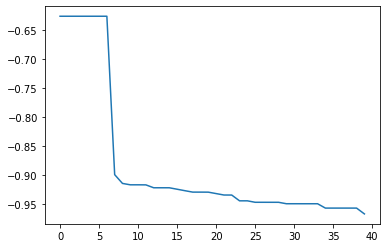

In [13]:
tmp['accuracy'].sort_values(ascending=False).reset_index(drop=True).plot()

The trade-off with parallelization, is that we will not optimize the search after each evaluation of f(x), instead after, in this case 4, evaluations of f(x). Thus, we may need to perform more evaluations to find the optima. But, because we do it in parallel, overall, we reduce wall time.

In [14]:
tmp.sort_values(by='accuracy', ascending=True)

,n_estimators,max_depth,min_samples_split,learning_rate,loss,accuracy
13,120,5,0.076970,0.855144,log_loss,-0.967343
21,120,1,0.089751,0.999000,log_loss,-0.957299
24,120,1,0.100000,0.999000,log_loss,-0.957280
29,120,1,0.100000,0.999000,exponential,-0.957280
26,120,5,0.100000,0.999000,log_loss,-0.957280
25,120,1,0.100000,0.235405,exponential,-0.957280
36,120,5,0.034251,0.999000,log_loss,-0.949761
35,65,1,0.041672,0.001000,exponential,-0.949761
16,120,1,0.077730,0.001000,log_loss,-0.949761
22,120,1,0.081837,0.999000,log_loss,-0.949742
